In [3]:
## updated Extended Forecasting up to 6th hour
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import os, time, json
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Hyperparameters
hidden_size = 64
num_layers = 2
dropout = 0.2
lr = 0.005
batch_size = 256
seq_length = 12
RAIN_THRESHOLD = 1.6
max_output_len = 6

# Load data
df = pd.read_csv(r'E:\Sumit\LSTM\LSTM_3_Years.csv')
data = df[['Precipitation', 'Temperature', 'SurfacePressure', 'RelativeHumidity', 'ZTD', 'Reflectivity', 'UComponentofWind']]
data = data.dropna().rolling(5).mean().dropna()

# Separate scalers
scaler_precip = MinMaxScaler()
scaler_feat = MinMaxScaler()

precip_scaled = scaler_precip.fit_transform(data[['Precipitation']])
feat_scaled = scaler_feat.fit_transform(data.drop(columns='Precipitation'))

data_scaled = np.concatenate([precip_scaled, feat_scaled], axis=1)

# Sequence generation
def create_sequences(data, seq_len, out_len):
    X, y = [], []
    for i in range(len(data) - seq_len - out_len + 1):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len:i+seq_len+out_len, 0])
    return np.array(X), np.array(y)

# Model definition
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        return self.fc(out)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs("results", exist_ok=True)

# Store metrics
summary_all = {}

for output_len in range(1, max_output_len + 1):
    start_time = time.time()
    X, y = create_sequences(data_scaled, seq_length, output_len)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test), batch_size=batch_size)

    model = LSTMModel(X_train.shape[2], hidden_size, output_len, num_layers).to(device)
    criterion = nn.SmoothL1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    best_loss, patience, counter = float('inf'), 5, 0
    train_losses, val_losses = [], []

    for epoch in range(1, 70):
        model.train()
        running_loss = 0
        for xb, yb in tqdm(train_loader, desc=f"Output {output_len}h - Epoch {epoch}", leave=False):
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                val_loss += criterion(pred, yb).item()
        val_loss /= len(test_loader)
        train_losses.append(running_loss / len(train_loader))
        val_losses.append(val_loss)
        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), f"results/best_model_out{output_len}.pth")
        else:
            counter += 1
            if counter >= patience:
                break

    # Load best model and evaluate
    model.load_state_dict(torch.load(f"results/best_model_out{output_len}.pth"))
    model.eval()
    preds = []
    with torch.no_grad():
        for xb, _ in test_loader:
            xb = xb.to(device)
            preds.append(model(xb).cpu().numpy())
    preds = np.vstack(preds)


    # Inverse transform each output value individually using fitted scaler
    y_pred_actual = scaler_precip.inverse_transform(preds)
    y_test_actual = scaler_precip.inverse_transform(y_test.numpy())


    # Save predictions
    np.savetxt(f"results/y_pred_out{output_len}.csv", y_pred_actual, delimiter=",")
    np.savetxt(f"results/y_true_out{output_len}.csv", y_test_actual, delimiter=",")

    # Evaluate metrics
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
    mae = mean_absolute_error(y_test_actual, y_pred_actual)
    r2 = r2_score(y_test_actual, y_pred_actual)

    y_true_bin = (y_test_actual >= RAIN_THRESHOLD).astype(int).flatten()
    y_pred_bin = (y_pred_actual >= RAIN_THRESHOLD).astype(int).flatten()

    TP = np.sum((y_true_bin == 1) & (y_pred_bin == 1))
    FP = np.sum((y_true_bin == 0) & (y_pred_bin == 1))
    FN = np.sum((y_true_bin == 1) & (y_pred_bin == 0))

    FAR = FP / (TP + FP + 1e-6)
    CSI = TP / (TP + FP + FN + 1e-6)
    precision = precision_score(y_true_bin, y_pred_bin, zero_division=0)
    recall = recall_score(y_true_bin, y_pred_bin, zero_division=0)
    f1 = f1_score(y_true_bin, y_pred_bin, zero_division=0)

    duration = round(time.time() - start_time, 2)
    summary_all[output_len] = {
        "RMSE": round(rmse, 4), "MAE": round(mae, 4), "R2": round(r2, 4),
        "FAR": round(FAR, 4), "CSI": round(CSI, 4),
        "Precision": round(precision, 4), "Recall": round(recall, 4), "F1": round(f1, 4),
        "Duration": duration
    }
    print(f"✅ Output {output_len}h - RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}, F1: {f1:.3f}")

# Save overall metrics
with open("results/multi_hour_metrics.json", "w") as f:
    json.dump(summary_all, f, indent=2)

print("\n📊 All multi-hour evaluation metrics saved in 'results/multi_hour_metrics.json'")


C:\Users\RCG\AppData\Local\Temp\ipykernel_41152\3158061688.py:120: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"results/best_model_out{ou

✅ Output 1h - RMSE: 1.104, MAE: 0.605, R²: 0.983, F1: 0.941


C:\Users\RCG\AppData\Local\Temp\ipykernel_41152\3158061688.py:120: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"results/best_model_out{ou

✅ Output 2h - RMSE: 1.921, MAE: 0.847, R²: 0.947, F1: 0.930


C:\Users\RCG\AppData\Local\Temp\ipykernel_41152\3158061688.py:120: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"results/best_model_out{ou

✅ Output 3h - RMSE: 2.670, MAE: 1.173, R²: 0.901, F1: 0.902


C:\Users\RCG\AppData\Local\Temp\ipykernel_41152\3158061688.py:120: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"results/best_model_out{ou

✅ Output 4h - RMSE: 3.127, MAE: 1.454, R²: 0.864, F1: 0.864


C:\Users\RCG\AppData\Local\Temp\ipykernel_41152\3158061688.py:120: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"results/best_model_out{ou

✅ Output 5h - RMSE: 3.478, MAE: 1.653, R²: 0.830, F1: 0.853


C:\Users\RCG\AppData\Local\Temp\ipykernel_41152\3158061688.py:120: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"results/best_model_out{ou

✅ Output 6h - RMSE: 3.929, MAE: 1.820, R²: 0.788, F1: 0.842

📊 All multi-hour evaluation metrics saved in 'results/multi_hour_metrics.json'


C:\Users\RCG\AppData\Local\Temp\ipykernel_41152\3556881179.py:33: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\RCG\AppData\Local\Temp\ipykernel_41152\3556881179.py:34: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig("rainfall_forecast_fixed_actual.png", dpi=300)
C:\Users\RCG\anaconda3\envs\torch-env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


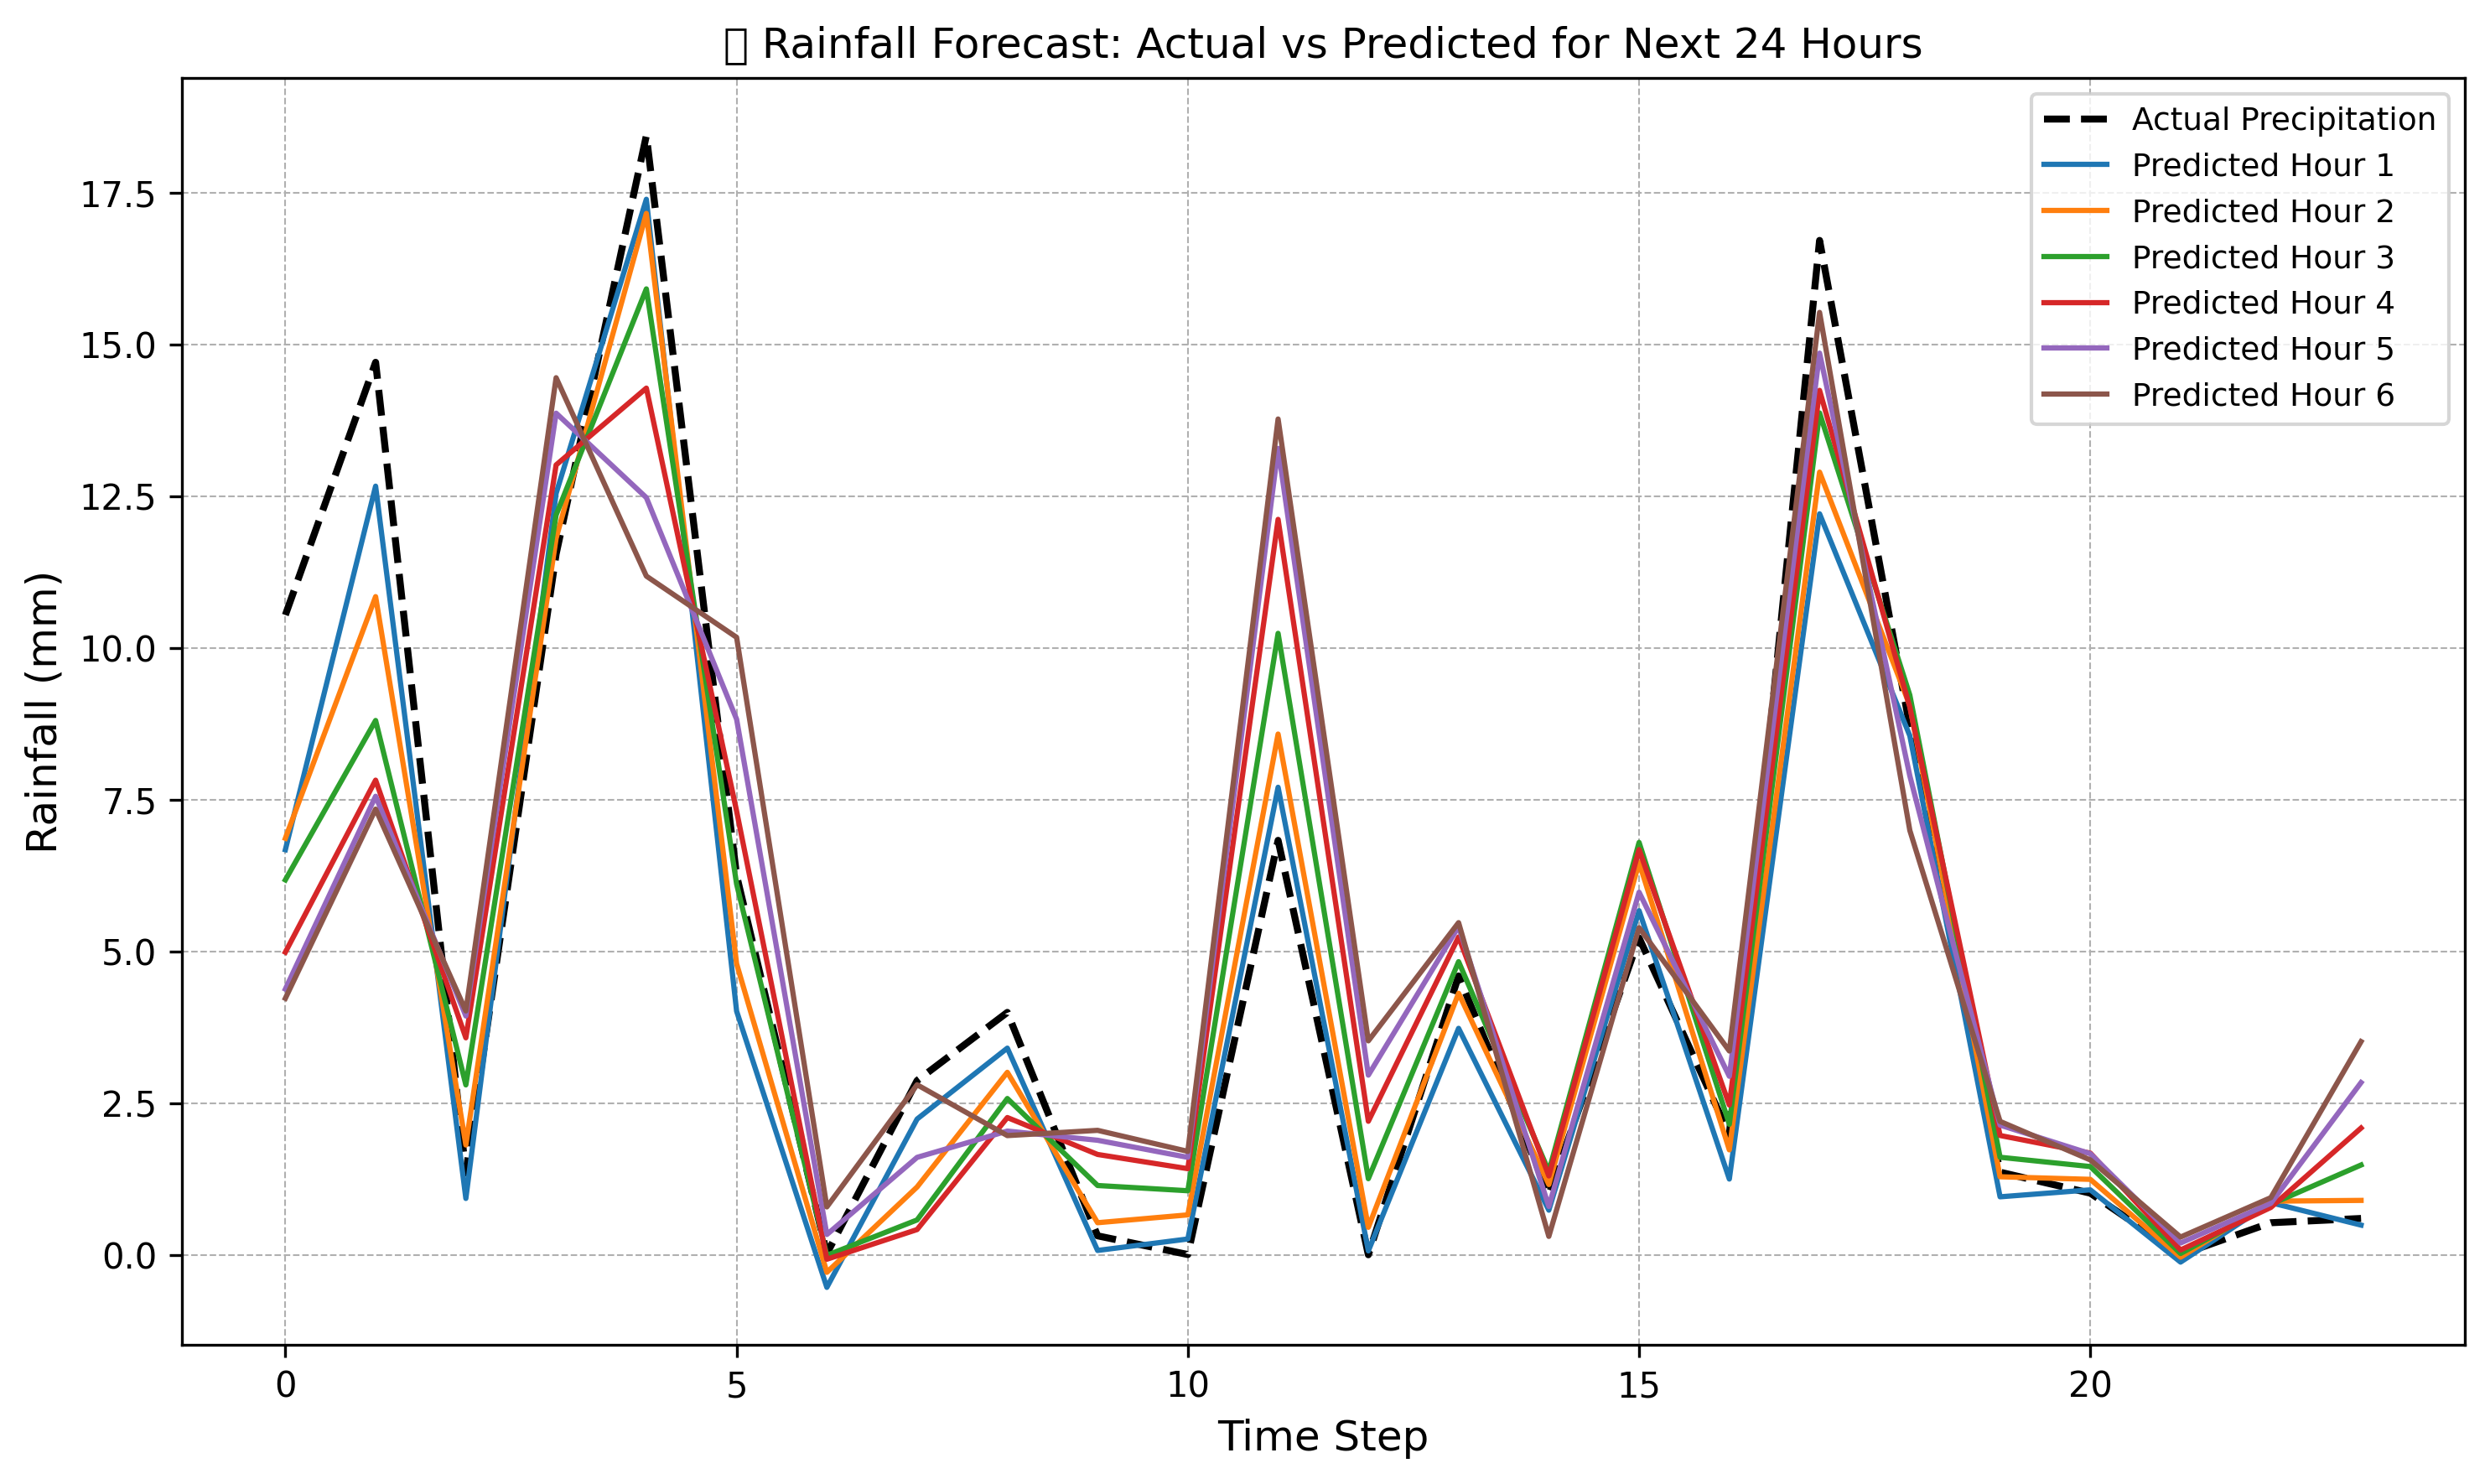

In [4]:
import matplotlib.pyplot as plt

# Define how many forecast hours you want to visualize
n_hours = y_pred_actual.shape[1]
n_samples_to_plot = 24  # Number of time steps to show

plt.figure(figsize=(10, 6), dpi=300)

# Plot Actual (Hour 1) once
plt.plot(
    y_test_actual[:n_samples_to_plot, 0],
    '--',
    color='black',
    label='Actual Precipitation',
    linewidth=2.0
)

# Overlay Predicted for each forecast hour
for i in range(n_hours):
    plt.plot(
        y_pred_actual[:n_samples_to_plot, i],
        label=f'Predicted Hour {i+1}',
        linewidth=1.5
    )

plt.title("📈 Rainfall Forecast: Actual vs Predicted for Next 24 Hours", fontsize=12)
plt.xlabel("Time Step", fontsize=12)
plt.ylabel("Rainfall (mm)", fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(fontsize=9)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig("rainfall_forecast_fixed_actual.png", dpi=300)
plt.show()
